In [1]:
import torch
import numpy as np
import glob
import os
import random
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

from torch import nn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

used some code from: https://github.com/seyma-tas/Brain-Tumor-Segmentation-Project/blob/master/2AdamW_DICE_BrainTumorGenesis.ipynb
also used: https://github.com/MrGiovanni/ModelsGenesis

# Accuracy and Loss Metrics

In [2]:
def dice_metric(inputs, target):
    num = target.shape[0]
    chans = target.shape[1]
    inputs = inputs.reshape(num, chans, -1)
    target = target.reshape(num, chans, -1)
    
    
    intersection = 2.0 * (target * inputs).sum(2)
    union = target.sum(2) + inputs.sum(2)
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return (intersection / union).mean()

def jaccard_index(inputs, target):
    num = target.shape[0]
    chans = target.shape[1]
    inputs = inputs.reshape(num, chans, -1)
    target = target.reshape(num, chans, -1)
    
    intersection = (target * inputs).sum(2)
    union = target.sum(2) + inputs.sum(2) - intersection
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return (intersection / union).mean()

# def dice_loss(inputs, target):
#     num = target.size(0)
#     chans = target.size(1)
#     inputs = inputs.reshape(num*chans, -1)
#     target = target.reshape(num*chans, -1)
#     smooth = 1.0
#     intersection = (inputs * target)
#     dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
#     dice = 1 - dice.sum() / (num*chans)
#     return dice

# def bce_dice_loss(inputs, target):
#     dicescore = dice_loss(inputs, target)
#     bcescore = nn.BCELoss()
#     bceloss = bcescore(inputs, target)

#     return bceloss + dicescore

def dice_loss(inputs, target):
    num = target.size(0)
    inputs = inputs.reshape(num, -1)
    target = target.reshape(num, -1)
    smooth = 1.0
    intersection = (inputs * target)
    dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
    dice = 1 - dice.sum() / num
    return dice

def bce_dice_loss(inputs, target):
    dicescore = dice_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

# Model
From https://github.com/MrGiovanni/ModelsGenesis

In [3]:


class ContBatchNorm2d(nn.modules.batchnorm._BatchNorm):
    def _check_input_dim(self, input):

        if input.dim() != 4:
            raise ValueError('expected 4D input (got {}D input)'.format(input.dim()))
        #super(ContBatchNorm3d, self)._check_input_dim(input)

    def forward(self, input):
        self._check_input_dim(input)
        return F.batch_norm(
            input, self.running_mean, self.running_var, self.weight, self.bias,
            True, self.momentum, self.eps)


class LUConv(nn.Module):
    def __init__(self, in_chan, out_chan, act):
        super(LUConv, self).__init__()
        self.conv1 = nn.Conv2d(in_chan, out_chan, kernel_size=3, padding=1)
        self.bn1 = ContBatchNorm2d(out_chan)

        if act == 'relu':
            self.activation = nn.ReLU(out_chan)
        elif act == 'prelu':
            self.activation = nn.PReLU(out_chan)
        elif act == 'elu':
            self.activation = nn.ELU(inplace=True)
        else:
            raise

    def forward(self, x):
        out = self.activation(self.bn1(self.conv1(x)))
        return out


def _make_nConv(in_channel, depth, act, double_chnnel=False):
    if double_chnnel:
        layer1 = LUConv(in_channel, 32 * (2 ** (depth+1)),act)
        layer2 = LUConv(32 * (2 ** (depth+1)), 32 * (2 ** (depth+1)),act)
    else:
        layer1 = LUConv(in_channel, 32*(2**depth),act)
        layer2 = LUConv(32*(2**depth), 32*(2**depth)*2,act)

    return nn.Sequential(layer1,layer2)

class DownTransition(nn.Module):
    def __init__(self, in_channel,depth, act):
        super(DownTransition, self).__init__()
        self.ops = _make_nConv(in_channel, depth,act)
        self.maxpool = nn.MaxPool2d(2)
        self.current_depth = depth

    def forward(self, x):
        if self.current_depth == 3:
            out = self.ops(x)
            out_before_pool = out
        else:
            out_before_pool = self.ops(x)
            out = self.maxpool(out_before_pool)
        return out, out_before_pool

class UpTransition(nn.Module):
    def __init__(self, inChans, outChans, depth,act):
        super(UpTransition, self).__init__()
        self.depth = depth
        self.up_conv = nn.ConvTranspose2d(inChans, outChans, kernel_size=2, stride=2)
        self.ops = _make_nConv(inChans+ outChans//2,depth, act, double_chnnel=True)

    def forward(self, x, skip_x):
        out_up_conv = self.up_conv(x)
        concat = torch.cat((out_up_conv,skip_x),1)
        out = self.ops(concat)
        return out


class OutputTransition(nn.Module):
    def __init__(self, inChans, n_labels):

        super(OutputTransition, self).__init__()
        self.final_conv = nn.Conv2d(inChans, n_labels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.sigmoid(self.final_conv(x))
        return out

class UNet2D(nn.Module):
    # the number of convolutions in each layer corresponds
    # to what is in the actual prototxt, not the intent
    def __init__(self, n_class=1, n_channels=1, act='relu'):
        super(UNet2D, self).__init__()

        self.down_tr64 = DownTransition(n_channels,0,act)
        self.down_tr128 = DownTransition(64,1,act)
        self.down_tr256 = DownTransition(128,2,act)
        self.down_tr512 = DownTransition(256,3,act)

        self.up_tr256 = UpTransition(512, 512,2,act)
        self.up_tr128 = UpTransition(256,256, 1,act)
        self.up_tr64 = UpTransition(128,128,0,act)
        self.out_tr = OutputTransition(64, n_class)

    def forward(self, x):
        self.out64, self.skip_out64 = self.down_tr64(x)
        self.out128,self.skip_out128 = self.down_tr128(self.out64)
        self.out256,self.skip_out256 = self.down_tr256(self.out128)
        self.out512,self.skip_out512 = self.down_tr512(self.out256)

        self.out_up_256 = self.up_tr256(self.out512,self.skip_out256)
        self.out_up_128 = self.up_tr128(self.out_up_256, self.skip_out128)
        self.out_up_64 = self.up_tr64(self.out_up_128, self.skip_out64)
        self.out = self.out_tr(self.out_up_64)

        return self.out



# Load and define dataset


In [4]:
class DatasetSegmentation(torch.utils.data.Dataset):
    def __init__(self, folder_path, interp_size = 512):
        super(DatasetSegmentation, self).__init__()
        self.interp_size = interp_size
        self.img_files = glob.glob(os.path.join(folder_path,'features','*.npy'))
        self.mask_files = []
        for img_path in self.img_files:
             self.mask_files.append(os.path.join(folder_path,'masks',os.path.basename(img_path)) )

    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]

        data = np.load(img_path)
        label = np.load(mask_path)

        data = torch.from_numpy(data).float()
        label = torch.from_numpy(label).float()
        data = F.interpolate(data.unsqueeze(0), (self.interp_size, self.interp_size)).squeeze(0)
        label = F.interpolate(label.unsqueeze(0), (self.interp_size, self.interp_size)).squeeze(0)
        return data, label

    def __len__(self):
        return len(self.img_files)

In [5]:
ds_train = DatasetSegmentation(os.path.join('data', 'yeast_processed_log_norm_area_50', 'train'))
ds_test = DatasetSegmentation(os.path.join('data', 'yeast_processed_log_norm_area_50', 'test'))
ds_val = DatasetSegmentation(os.path.join('data', 'yeast_processed_log_norm_area_50', 'val'))

In [6]:
ds_train.__len__(), ds_test.__len__()

(892, 111)

In [7]:
sample = ds_train.__getitem__(12)

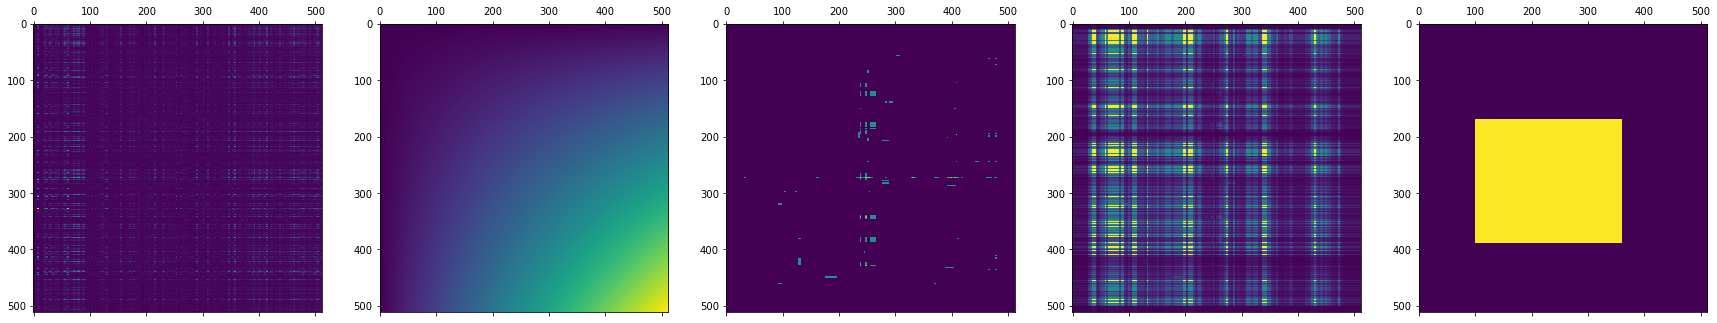

In [8]:
fig, axs = plt.subplots(1,5, figsize=(30,30))
axs[0].matshow(sample[0][0].view(512,512))
axs[1].matshow(sample[0][1].view(512,512))
axs[2].matshow(sample[0][2].view(512,512))
axs[3].matshow(sample[0][3].view(512,512))
axs[4].matshow(sample[1][0].view(512,512))
plt.show()

In [9]:
train_dataloader = torch.utils.data.DataLoader(ds_train, batch_size=2, num_workers=0, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(ds_test, batch_size=2, num_workers=0, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(ds_val, batch_size=2, num_workers=0, shuffle=False)

# Setup Model 

In [10]:
model = UNet2D(n_class=sample[1].shape[0], n_channels=sample[0].shape[0])

## Parameters
Setup loss function:

In [11]:
# def dice_metric(inputs, target):
#     intersection = 2.0 * (target * inputs).sum()
#     union = target.sum() + inputs.sum()
#     if target.sum() == 0 and inputs.sum() == 0:
#         return 1.0

#     return intersection / union

# def dice_loss(inputs, target):
#     num = target.size(0)
#     inputs = inputs.reshape(num, -1)
#     target = target.reshape(num, -1)
#     smooth = 1.0
#     intersection = (inputs * target)
#     dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
#     dice = 1 - dice.sum() / num
#     return dice

# def bce_dice_loss(inputs, target):
#     dicescore = dice_loss(inputs, target)
#     bcescore = nn.BCELoss()
#     bceloss = bcescore(inputs, target)

#     return bceloss + dicescore

criterion = bce_dice_loss

Setup optimizer

In [12]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=0.1)

In [13]:
from torch.optim import lr_scheduler 
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Prepare Training

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Train

Start train...


Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Batch:   0%|          | 0/446 [00:00<?, ?it/s]

epoch 0 train loss 1.3174400415121172 val loss 1.301596230694226
epoch 1 train loss 1.311347110121774 val loss 1.302798718214035
epoch 2 train loss 1.3105282735396928 val loss 1.3041663425309318
epoch 3 train loss 1.311492235403959 val loss 1.3062721256698882
epoch 4 train loss 1.3116256110871318 val loss 1.3041281529835291
epoch 5 train loss 1.3118263266546308 val loss 1.3016024274485452
epoch 6 train loss 1.3100680730268026 val loss 1.302919179201126
epoch 7 train loss 1.3098775137700307 val loss 1.3015362109456743
epoch 8 train loss 1.310787048575055 val loss 1.3021751131330217
epoch 9 train loss 1.3095127905430815 val loss 1.3030971544129508
epoch 10 train loss 1.309036186190464 val loss 1.3067758594240462
epoch 11 train loss 1.3087116258026774 val loss 1.3023228560175215
epoch 12 train loss 1.3089461575174546 val loss 1.3042991374220168
epoch 13 train loss 1.3093476618886528 val loss 1.301432573369571
epoch 14 train loss 1.308555077276957 val loss 1.3019877565758569
epoch 15 train

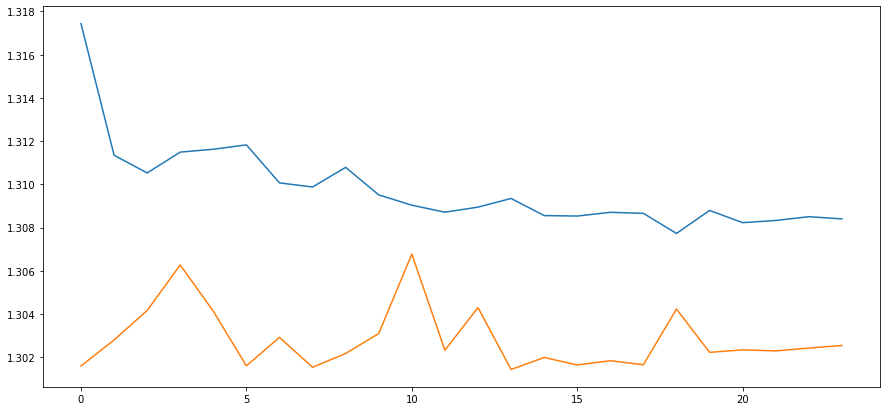

In [15]:
from tqdm.autonotebook import tqdm

if not os.path.isdir('models/unet2D/yeast_processed_log_norm_area_50/'):
    os.mkdir('models/unet2D/yeast_processed_log_norm_area_50/')


epochs = 1000

model.to(device)

# Initialize lists to store loss values
loss_history = []
loss_history_val = []

best_loss_val = float('inf')


early_stop_count = 0
# Train
print("Start train...")
outer = tqdm(total=epochs, desc='Epochs', position=0)
inner = tqdm(total=len(train_dataloader), desc=f'Batch', position=1)
for epoch in range(epochs):
    # check to see if validation loss has plateau'd
    if early_stop_count >= 10:
        print(f'Validation loss plateaud; failed to improve after {early_stop_count} at {epoch}th epoch')
        checkpoint = { 
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler}
        torch.save(checkpoint, f'./models/unet2D/yeast_processed_log_norm_area_50/checkpt_earlystop_{epoch}.pth')
        break
    
    early_stop_count += 1
    
   #Train mode
    model.train()
    loss_running = []
    
    inner.refresh()  #force print final state
    inner.reset()  #reuse bar    
    for _, (x,y) in enumerate(train_dataloader):
        x, y = x.float().to(device), y.float().to(device)
        
        pred = model(x)
        loss = criterion(pred, y)
        loss_running.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        inner.update(1)
        
    loss_history.append(np.mean(loss_running))
    # Evaluate mode
    model.eval()
    with torch.no_grad():
        loss_val_running = []
        for _, (x_val, y_val) in enumerate(val_dataloader):
            x_val, y_val = x_val.to(device), y_val.to(device)
            pred_val = model.forward(x_val) #pred_val = model(x_val)
            loss_val= criterion(pred_val, y_val)
            loss_val_running.append(loss_val.item())
    
    
    curr_loss_val = np.mean(loss_val_running)
    loss_history_val.append(curr_loss_val)
    
    # Change the learning rate
    scheduler.step()
    
    # Save the best weights
    if curr_loss_val < best_loss_val:
        best_loss_val = curr_loss_val
        checkpoint = { 
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler}
        torch.save(checkpoint, './models/unet2D/yeast_processed_log_norm_area_50/best_model.pth')
        early_stop_count = 0
    
    # Save checkpoint every 10
    if epoch % 10 == 0 or epoch >= 1-epochs:
        checkpoint = { 
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler}
        torch.save(checkpoint, f'./models/unet2D/yeast_processed_log_norm_area_50/checkpt{epoch}.pth')
        
    # Print the results    
    outer.update(1)
    print("epoch", epoch, "train loss", loss_history[-1], "val loss", loss_history_val[-1])


# Print loss history
plt.figure(figsize=(15, 7))
plt.plot(loss_history)
plt.plot(loss_history_val)

# Evaluate

In [16]:
checkpoint = torch.load('./models/unet2D/yeast_processed_log_norm_area_50/best_model.pth',
                        map_location=torch.device('cpu'))

model = checkpoint['model']
model.cuda()
model.eval()
torch.set_grad_enabled(False)

In [17]:
# def mask_to_box(mask, tail=0.0):
#     cumsum_b = np.cumsum(mask.sum(0))
#     cumsum_a = np.cumsum(mask.sum(1))
    
#     # right at beginning of range makes sure it searches for the first index not of the value
#     # left at end of range makes sure it searches for the last index of the value
#     range_a = (np.searchsorted(cumsum_a, np.quantile(cumsum_a, tail), side='right'), np.searchsorted(cumsum_a, np.quantile(cumsum_a, 1.0-tail), side='left'))
#     range_b = (np.searchsorted(cumsum_b, np.quantile(cumsum_b, tail), side='right'), np.searchsorted(cumsum_b, np.quantile(cumsum_b, 1.0-tail), side='left'))
#     return range_a, range_b
from scipy import ndimage
def mask_to_box(a):
    objs = ndimage.find_objects(a, max_label=1)

    # Get the height and width
    return objs

In [18]:
# import matplotlib

# cmap = mpl.cm.ScalarMappable
# norm = mpl.colors.Normalize(vmin=0, vmax=1)

# cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
#                                 norm=norm)
from matplotlib.patches import Rectangle

def plot_mask(mask_cpu, axx, round=False, title=None, bbs=[]):
    # takes 64*64*64 array
    mask_cpu = mask_cpu.cpu().detach().numpy()
    if round:
        mask_cpu = np.round(mask_cpu)
    ax = axx.matshow(mask_cpu)
    if title:
        axx.set_title(title)
    axx.set_ylabel('Sequence A')
    axx.set_xlabel('Sequence B')
    ax.set_clim(0, 1)
    axx.set_xticks([])
    axx.set_yticks([])
    
    for bb in bbs:
        if bb:
            rect = Rectangle((bb[1].start,bb[0].start),bb[1].stop-bb[1].start,bb[0].stop-bb[0].start,linewidth=1,edgecolor='r',facecolor='none')

            # Add the patch to the Axes
            axx.add_patch(rect)
    
    plt.colorbar(ax, ax=axx)

<ipython-input-19-fbfecd6ff246>:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bbs = mask_to_box(pred[0,0,:,:].cpu().numpy().round().astype(np.int))


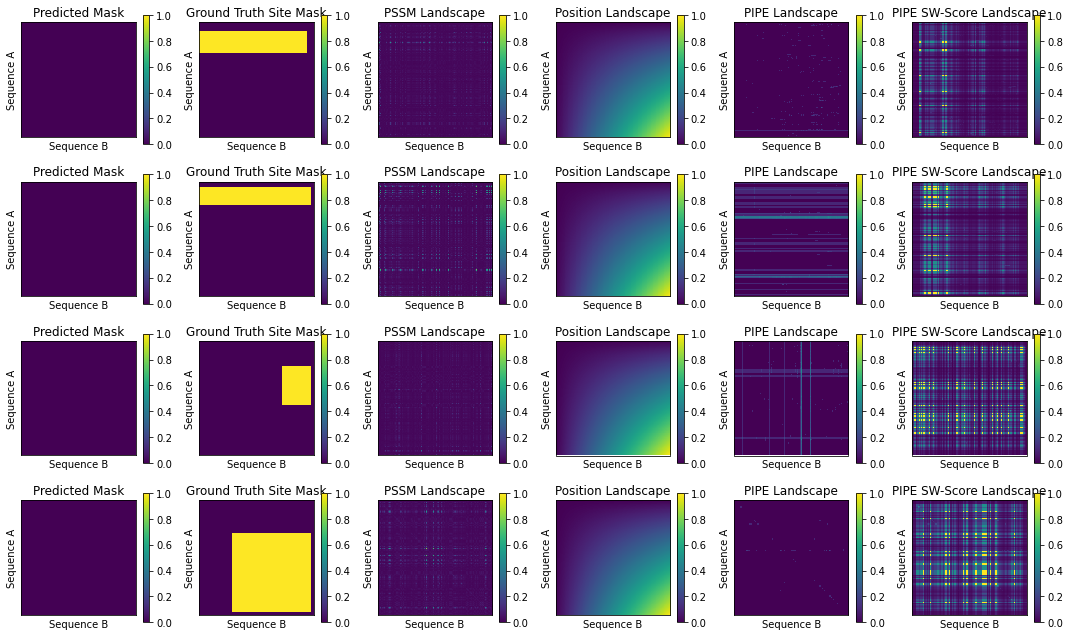

In [19]:
dataloader = test_dataloader
ncol = 6
nrows=4
random.seed(839)
rand_ndx = random.sample(range(0, len(dataloader)), nrows)
fig, ax = plt.subplots(nrows=nrows,  ncols=ncol, figsize=(15, 9))
i = 0
for n, (x, y) in enumerate(dataloader):
    x, y = x.to(device), y.to(device)
    if n in rand_ndx:
        pred = model.forward(x)

        # calculate bounding boxes
        bbs = mask_to_box(pred[0,0,:,:].cpu().numpy().round().astype(np.int))
#         bb25 = mask_to_box(pred[0,0,:,:], tail=0.25)
#         bb33 = mask_to_box(pred[0,0,:,:], tail=0.4)
        
        plot_mask(pred[0,0,:,:], ax[i][0], round=True, title="Predicted Mask", bbs=bbs)
        plot_mask(y[0,0,:,:], ax[i][1], title='Ground Truth Site Mask', bbs=bbs)
        plot_mask(x[0,0,:,:], ax[i][2], title='PSSM Landscape', bbs=bbs)
        plot_mask(x[0,1,:,:], ax[i][3], title='Position Landscape', bbs=bbs)
        plot_mask(x[0,2,:,:], ax[i][4], title='PIPE Landscape', bbs=bbs)
        plot_mask(x[0,3,:,:], ax[i][5], title='PIPE SW-Score Landscape', bbs=bbs)
        i+=1
        
plt.tight_layout()

# Function to compute the dice accuracy

In [20]:
def compute_acc(dataloader, model):
    acc = []
    loss = []
    jacc = []
    #model.eval()
    #with torch.no_grad():
    for _, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss.append(bce_dice_loss(pred, y).item())
        # loss.append(BCELoss)    
        acc.append(dice_metric(pred.data.cpu().numpy().round(), y.data.cpu().numpy()))
        jacc.append(jaccard_index(pred.data.cpu().numpy().round(), y.data.cpu().numpy()))
       
    print(f'Loss: {np.mean(loss)}, Accuracy (dice): {np.mean(acc)}, Jaccard Index: {np.mean(jacc)}')

# Compute dice accuracy for train, validation and test data

In [21]:
compute_acc(test_dataloader, model)

Loss: 1.299216559955052, Accuracy (dice): 0.0, Jaccard Index: 0.0


In [22]:
compute_acc(train_dataloader, model)

Loss: 1.3084299187489155, Accuracy (dice): 0.0, Jaccard Index: 0.0


In [23]:
compute_acc(val_dataloader, model)

Loss: 1.301432573369571, Accuracy (dice): 0.0, Jaccard Index: 0.0


## Test totally random

In [24]:
model = UNet2D(n_class=sample[1].shape[0], n_channels=sample[0].shape[0])
model.cuda()
model.eval()
compute_acc(test_dataloader, model)

Loss: 1.468889757990837, Accuracy (dice): 0.20584668219089508, Jaccard Index: 0.12352918833494186


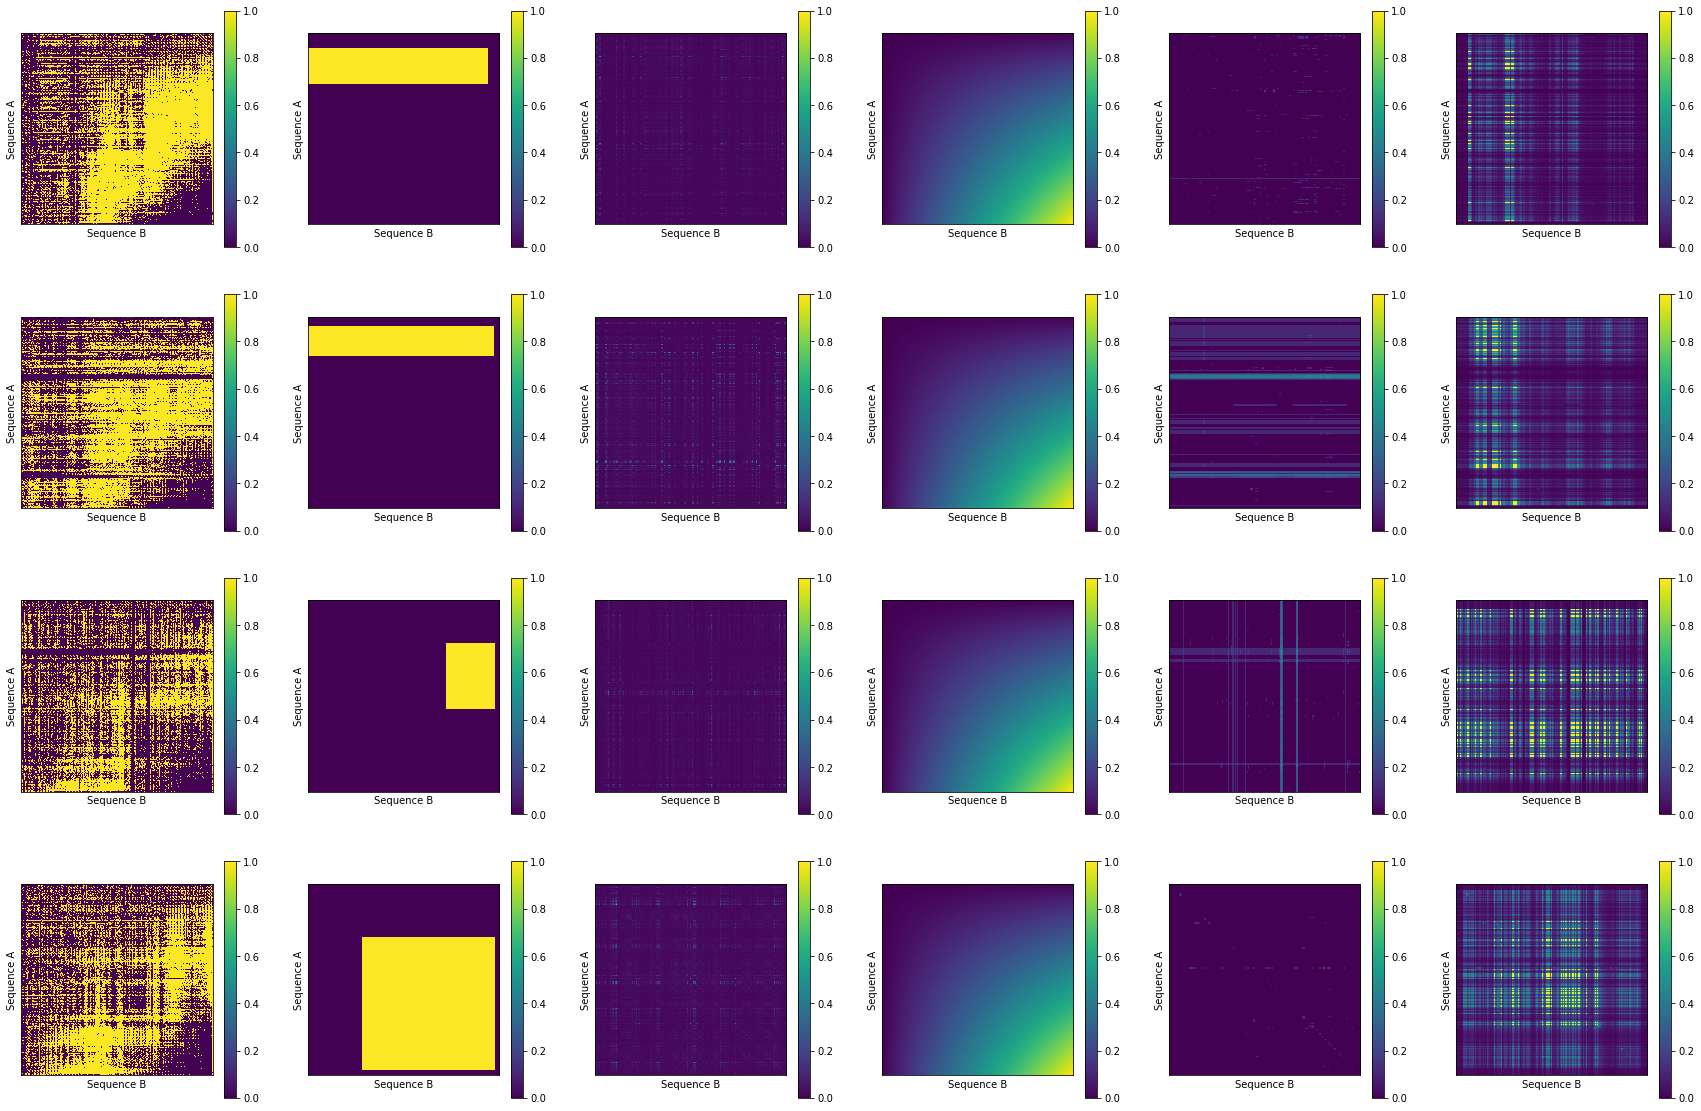

In [25]:
dataloader = test_dataloader
ncol = 6
nrows=4
random.seed(839)
rand_ndx = random.sample(range(0, len(dataloader)), nrows)
fig, ax = plt.subplots(nrows=nrows,  ncols=ncol, figsize=(30, 20))
i = 0
for n, (x, y) in enumerate(dataloader):
    x, y = x.to(device), y.to(device)
    if n in rand_ndx:
        pred = model.forward(x)
        plot_mask(pred[0,0,:,:], ax[i][0], round=True)
        plot_mask(y[0,0,:,:], ax[i][1])
        plot_mask(x[0,0,:,:], ax[i][2])
        plot_mask(x[0,1,:,:], ax[i][3])
        plot_mask(x[0,2,:,:], ax[i][4])
        plot_mask(x[0,3,:,:], ax[i][5])
        i+=1

# Convert to bounding boxes

Create dataset object that can take pair names

In [26]:
class DatasetBB(torch.utils.data.Dataset):
    def __init__(self, folder_path, interp_size = 512):
        super(DatasetBB, self).__init__()
        self.interp_size = interp_size
        self.img_files = glob.glob(os.path.join(folder_path,'features','*.npy'))
        self.mask_files = []
        self.pair_names = []
        for img_path in self.img_files:
            self.mask_files.append(os.path.join(folder_path,'masks',os.path.basename(img_path)) )
            self.pair_names.append(os.path.splitext(os.path.basename(img_path))[0])

    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]

        data = np.load(img_path)
        label = np.load(mask_path)

        data = torch.from_numpy(data).float()
        label = torch.from_numpy(label).float()
        data = F.interpolate(data.unsqueeze(0), (self.interp_size, self.interp_size)).squeeze(0)
        label = F.interpolate(label.unsqueeze(0), (self.interp_size, self.interp_size)).squeeze(0)
        return data, label, self.pair_names[index]

    def __len__(self):
        return len(self.img_files)

In [27]:
ds_test = DatasetBB(os.path.join('data', 'yeast_processed_log_norm_area_50', 'test'))
ds_val = DatasetBB(os.path.join('data', 'yeast_processed_log_norm_area_50', 'val'))

In [28]:
ds_test.__getitem__(0)

(tensor([[[2.4737e-02, 2.4737e-02, 2.5345e-02,  ..., 3.2462e-02,
           3.2462e-02, 1.7099e-02],
          [2.4737e-02, 2.4737e-02, 2.5345e-02,  ..., 3.2462e-02,
           3.2462e-02, 1.7099e-02],
          [2.4130e-02, 2.4130e-02, 2.6300e-02,  ..., 3.4546e-02,
           3.4546e-02, 1.7099e-02],
          ...,
          [1.6231e-02, 1.6231e-02, 1.6144e-02,  ..., 1.9096e-02,
           1.9096e-02, 3.3678e-02],
          [1.8054e-02, 1.8054e-02, 1.8835e-02,  ..., 2.8991e-02,
           2.8991e-02, 2.2073e-01],
          [1.5971e-02, 1.5971e-02, 1.5190e-02,  ..., 1.6318e-02,
           1.6318e-02, 2.6126e-02]],
 
         [[6.2924e-06, 6.2924e-06, 1.2585e-05,  ..., 1.9507e-03,
           1.9507e-03, 1.9569e-03],
          [6.2924e-06, 6.2924e-06, 1.2585e-05,  ..., 1.9507e-03,
           1.9507e-03, 1.9569e-03],
          [1.2585e-05, 1.2585e-05, 2.5170e-05,  ..., 3.9013e-03,
           3.9013e-03, 3.9139e-03],
          ...,
          [3.2028e-03, 3.2028e-03, 6.4057e-03,  ..., 9.928

In [29]:
test_dl = torch.utils.data.DataLoader(ds_test, batch_size=1, num_workers=0, shuffle=False)
val_dl = torch.utils.data.DataLoader(ds_val, batch_size=1, num_workers=0, shuffle=False)

In [30]:
# data, mask, pairname = iter(test_dl).next()

In [31]:
# data.shape, mask.shape

In [32]:
# mask.to(device)

In [33]:
# pred = model(data.to(device))

In [34]:
# pred.shape

In [35]:
# torch.randn(2, 4).sum(0)

In [36]:
# cumsum_b = np.cumsum(pred.view(512,512).sum(0).cpu().numpy())
# cumsum_a = np.cumsum(pred.view(512,512).sum(1).cpu().numpy())

In [37]:
# tail=0.25
# np.searchsorted(cumsum_b, np.quantile(cumsum_b, tail)), np.searchsorted(cumsum_b, np.quantile(cumsum_b, 1-tail))

In [38]:
# plt.matshow(pred[0,0,:,:].detach().cpu().numpy())
# plt.colorbar()

In [39]:
# plt.matshow(mask[0,0,:,:].detach().cpu().numpy())
# plt.colorbar()

In [40]:
# def mask_to_box(mask, tail=0.0):
#     cumsum_b = np.cumsum(mask[0,0,:,:].max(0).cpu().numpy())
#     cumsum_a = np.cumsum(mask[0,0,:,:].max(1).cpu().numpy())
    
#     # right at beginning of range makes sure it searches for the first index not of the value
#     # left at end of range makes sure it searches for the last index of the value
#     range_a = (np.searchsorted(cumsum_a, np.quantile(cumsum_a, tail), side='right'), np.searchsorted(cumsum_a, np.quantile(cumsum_a, 1-tail), side='left'))
#     range_b = (np.searchsorted(cumsum_b, np.quantile(cumsum_b, tail), side='right'), np.searchsorted(cumsum_b, np.quantile(cumsum_b, 1-tail), side='left'))
#     return range_a, range_b

In [41]:
# cumsum_b = np.cumsum(np.round(pred[0,0,:,:].cpu().numpy().max(axis=0)))
# cumsum_a = np.cumsum(np.round(pred[0,0,:,:].cpu().numpy().max(axis=1)))

In [42]:
# plt.plot(cumsum_b)

In [43]:
# plt.plot(cumsum_a)

In [44]:
# tail=0.20
# (np.searchsorted(cumsum_a, np.quantile(cumsum_a, tail), side='right'), np.searchsorted(cumsum_a, np.quantile(cumsum_a, 1-tail), side='left'))

In [45]:
# (np.searchsorted(cumsum_b, np.quantile(cumsum_b, tail), side='right'), np.searchsorted(cumsum_b, np.quantile(cumsum_b, 1-tail), side='left'))

In [46]:
# np.quantile(cumsum_a, tail)

In [47]:
# np.quantile(cumsum_b, tail)

In [48]:
# ndimage.find_objects(np.zeros((50,50), dtype=np.int), max_label=1)

In [49]:
# plt.matshow(pred[0,0,:,:].cpu().numpy().round().astype(int))

In [50]:
# mask_to_box(mask[0,0,:,:].cpu().numpy().round().astype(int))

## Get predictions and turn them into bounding boxes

In [51]:
checkpoint = torch.load('./models/unet2D/yeast_processed_log_norm_area_50/best_model.pth',
                        map_location=torch.device('cpu'))

model = checkpoint['model']
model.cuda()
model.eval()
torch.set_grad_enabled(False)


bb_preds_test = []
bb_trues_test = []
pairnames_test = []
for _, (data, mask, pairname) in enumerate(test_dl):
    data, mask = data.to(device), mask.to(device)
    
    pred = model(data)
    
    pred = pred[0,0,:,:].cpu().numpy().round().astype(np.int32)
    mask = mask[0,0,:,:].cpu().numpy().round().astype(np.int32)
    
    bb_preds_test.append(mask_to_box(pred))
    bb_trues_test.append(mask_to_box(mask))
    pairnames_test.append(pairname)
    
bb_preds_val = []
bb_trues_val = []
pairnames_val = []
for _, (data, mask, pairname) in enumerate(val_dl):
    data, mask = data.to(device), mask.to(device)
    
    pred = model(data)
    
    pred = pred[0,0,:,:].cpu().numpy().round().astype(np.int32)
    mask = mask[0,0,:,:].cpu().numpy().round().astype(np.int32)
    
    bb_preds_val.append(mask_to_box(pred))
    bb_trues_val.append(mask_to_box(mask))
    pairnames_val.append(pairname)
    
import pandas as pd
test_df = pd.DataFrame(list(zip(pairnames_test, bb_preds_test, bb_trues_test)), columns=['pair', 'pred', 'true'])
val_df = pd.DataFrame(list(zip(pairnames_val, bb_preds_val, bb_trues_val)), columns=['pair', 'pred', 'true'])

In [52]:
test_df

,pair,pred,true
0,"(P00830_P38077,)",[None],"[(slice(170, 389, None), slice(56, 511, None))]"
1,"(P06245_P05986,)",[None],"[(slice(93, 437, None), slice(112, 440, None))]"
2,"(P06780_P51862,)",[None],"[(slice(27, 454, None), slice(250, 319, None))]"
3,"(P06782_P38717,)",[None],"[(slice(44, 248, None), slice(129, 177, None))]"
4,"(P08018_P53599,)",[None],"[(slice(276, 478, None), slice(411, 506, None))]"
...,...,...,...
106,"(Q12189_Q12189,)",[None],"[(slice(145, 499, None), slice(145, 499, None))]"
107,"(Q12223_Q12223,)",[None],"[(slice(99, 433, None), slice(99, 433, None))]"
108,"(Q12329_Q12329,)",[None],"[(slice(336, 487, None), slice(336, 487, None))]"
109,"(Q12438_Q12438,)",[None],"[(slice(282, 428, None), slice(282, 428, None))]"


In [53]:
# -1 to make inclusive
deslice = lambda x: np.asarray([[x[0][0].start, x[0][0].stop-1], [x[0][1].start, x[0][1].stop-1]])

In [54]:
test_df[['pred', 'true']] = test_df[['pred', 'true']].applymap(deslice)
val_df[['pred', 'true']] = val_df[['pred', 'true']].applymap(deslice)

TypeError: 'NoneType' object is not subscriptable

In [ ]:
test_df

Get lengths of proteins

In [ ]:
protein_sequence = "data/uniprot-proteome_UP000002311_stripped.fasta"
protein_sequence_CD = pd.read_csv(protein_sequence, header = None, sep = "\t")
print("Loaded UniProt proteome")
new_df_ps = pd.DataFrame(index = protein_sequence_CD[0].iloc[::2].map(lambda x: str(x)[1:].strip()))
new_df_ps['Sequence'] = protein_sequence_CD[0].iloc[1::2].to_numpy()
new_df_ps['Length'] = new_df_ps['Sequence'].map(lambda x: len(x))
new_df_ps

In [ ]:
test_df['pair'] = test_df['pair'].apply(lambda x: x[0]).str.split(pat='_')
test_df

In [ ]:
test_df[['protein_a', 'protein_b']] = pd.DataFrame(test_df['pair'].tolist(), index=test_df.index)
test_df.drop(['pair'], inplace=True, axis=1)
test_df

In [ ]:
test_df['len_a'] = test_df['protein_a'].apply(lambda x: new_df_ps.Length.loc[x])
test_df['len_b'] = test_df['protein_b'].apply(lambda x: new_df_ps.Length.loc[x])
test_df

In [ ]:
# Formula adapted from https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation
def get_dice_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : list: [[y1, y2], [x1, x2]]
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb1 : list: [[y1, y2], [x1, x2]]
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """

    assert bb1[0][0] < bb1[0][1]
    assert bb1[1][0] < bb1[1][1]
    assert bb2[0][0] < bb2[0][1]
    assert bb2[1][0] < bb2[1][1]

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[1][0], bb2[1][0])
    y_top = max(bb1[0][0], bb2[0][0])
    x_right = min(bb1[1][1], bb2[1][1])
    y_bottom = min(bb1[0][1], bb2[0][1])

    if x_right < x_left or y_bottom < y_top:
        return 0.0, 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left + 1) * (y_bottom - y_top + 1)

    # compute the area of both AABBs
    bb1_area = (bb1[1][1] - bb1[1][0] + 1) * (bb1[0][1] - bb1[0][0] + 1)
    bb2_area = (bb2[1][1] - bb2[1][0] + 1) * (bb2[0][1] - bb2[0][0] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    
    # dice
    dice =  2 * intersection_area / float(bb1_area + bb2_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou, dice

In [ ]:
test_df['iou_dice'] = test_df.apply(lambda x: get_dice_iou(x.pred, x.true), axis=1)
test_df[['iou', 'dice']] = pd.DataFrame(test_df['iou_dice'].tolist(), index=test_df.index)
test_df.drop(['iou_dice'], inplace=True, axis=1)

val_df['iou_dice'] = val_df.apply(lambda x: get_dice_iou(x.pred, x.true), axis=1)
val_df[['iou', 'dice']] = pd.DataFrame(val_df['iou_dice'].tolist(), index=val_df.index)
val_df.drop(['iou_dice'], inplace=True, axis=1)

In [ ]:
test_df

In [ ]:
val_df

## Distance Measure

The distance measure is as described in PIPE-Sites: https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-12-225

In [ ]:
def dm(pred, true, len_a, len_b):
    
    assert pred[0][0] < pred[0][1]
    assert pred[1][0] < pred[1][1]
    assert true[0][0] < true[0][1]
    assert true[1][0] < true[1][1]
    
    delta_a = max(true[0][0]-pred[0][0], pred[0][1]-true[0][1], 0)/len_a
    delta_b = max(true[1][0]-pred[1][0], pred[1][1]-true[1][1], 0)/len_b
    
    result = ((delta_a**2 + delta_b**2)**0.5)/(2**0.5)
    
    return result

In [ ]:
test_df['dm'] = test_df.apply(lambda x: dm(x.pred, x.true, 512, 512), axis=1)
test_df

In [ ]:
test_df[['iou', 'dice', 'dm']].describe()